## Using ResNet50 as baseline method

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_dir = "data/train"
val_dir = "data/val"

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # binary classification (logit)
model = model.to(device)

/home/mperform/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mperform/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/mperform/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s] 


In [7]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print("Done setup")

Done setup


In [10]:
num_epochs = 20
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # [B, 1]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_auc = roc_auc_score(targets, preds)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, AUC = {val_auc:.4f}")


Epoch 1/20: 100%|██████████| 11336/11336 [07:22<00:00, 25.63it/s]


Epoch 1: Train Loss = 0.0067, Val Loss = 0.0853, AUC = 0.1578


Epoch 2/20: 100%|██████████| 11336/11336 [07:18<00:00, 25.83it/s]


Epoch 2: Train Loss = 0.0064, Val Loss = 0.1637, AUC = 0.1551


Epoch 3/20: 100%|██████████| 11336/11336 [07:20<00:00, 25.75it/s]


Epoch 3: Train Loss = 0.0063, Val Loss = 0.0065, AUC = 0.9789


Epoch 4/20: 100%|██████████| 11336/11336 [07:22<00:00, 25.59it/s]


Epoch 4: Train Loss = 0.0061, Val Loss = 0.0677, AUC = 0.2127


Epoch 5/20: 100%|██████████| 11336/11336 [07:22<00:00, 25.62it/s]


Epoch 5: Train Loss = 0.0060, Val Loss = 0.0060, AUC = 0.9885


Epoch 6/20: 100%|██████████| 11336/11336 [07:21<00:00, 25.68it/s]


Epoch 6: Train Loss = 0.0059, Val Loss = 0.0528, AUC = 0.5526


Epoch 7/20: 100%|██████████| 11336/11336 [07:21<00:00, 25.65it/s]


Epoch 7: Train Loss = 0.0057, Val Loss = 0.1769, AUC = 0.1482


Epoch 8/20: 100%|██████████| 11336/11336 [07:22<00:00, 25.59it/s]


Epoch 8: Train Loss = 0.0056, Val Loss = 0.2836, AUC = 0.1567


Epoch 9/20: 100%|██████████| 11336/11336 [07:22<00:00, 25.64it/s]


Epoch 9: Train Loss = 0.0056, Val Loss = 0.0600, AUC = 0.4654


Epoch 10/20: 100%|██████████| 11336/11336 [07:21<00:00, 25.68it/s]


Epoch 10: Train Loss = 0.0055, Val Loss = 0.0844, AUC = 0.2684


Epoch 11/20: 100%|██████████| 11336/11336 [07:24<00:00, 25.49it/s]


Epoch 11: Train Loss = 0.0055, Val Loss = 0.0291, AUC = 0.8595


Epoch 12/20: 100%|██████████| 11336/11336 [07:19<00:00, 25.81it/s]


Epoch 12: Train Loss = 0.0053, Val Loss = 0.2317, AUC = 0.1561


Epoch 13/20: 100%|██████████| 11336/11336 [07:19<00:00, 25.78it/s]


Epoch 13: Train Loss = 0.0053, Val Loss = 0.3857, AUC = 0.1574


Epoch 14/20: 100%|██████████| 11336/11336 [07:20<00:00, 25.73it/s]


Epoch 14: Train Loss = 0.0051, Val Loss = 0.1993, AUC = 0.1558


Epoch 15/20: 100%|██████████| 11336/11336 [07:20<00:00, 25.71it/s]


Epoch 15: Train Loss = 0.0051, Val Loss = 0.0396, AUC = 0.6917


Epoch 16/20: 100%|██████████| 11336/11336 [07:18<00:00, 25.87it/s]


Epoch 16: Train Loss = 0.0049, Val Loss = 0.1504, AUC = 0.1755


Epoch 17/20: 100%|██████████| 11336/11336 [07:23<00:00, 25.54it/s]


Epoch 17: Train Loss = 0.0049, Val Loss = 0.4030, AUC = 0.1565


Epoch 18/20: 100%|██████████| 11336/11336 [07:21<00:00, 25.70it/s]


Epoch 18: Train Loss = 0.0047, Val Loss = 0.5952, AUC = 0.1517


Epoch 19/20: 100%|██████████| 11336/11336 [07:21<00:00, 25.68it/s]


Epoch 19: Train Loss = 0.0046, Val Loss = 0.1051, AUC = 0.2752


Epoch 20/20: 100%|██████████| 11336/11336 [07:21<00:00, 25.66it/s]


Epoch 20: Train Loss = 0.0054, Val Loss = 0.5204, AUC = 0.1565


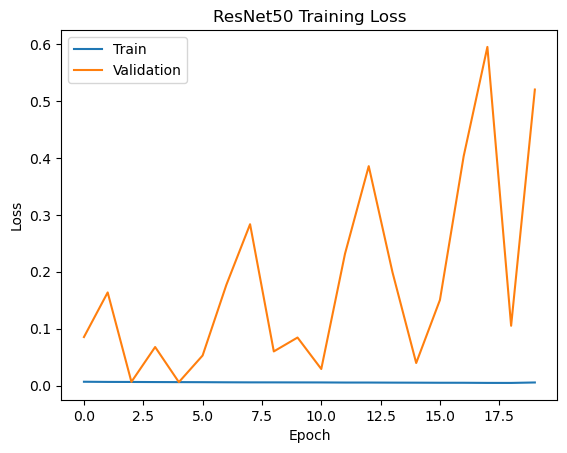

In [11]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Training Loss")
plt.legend()
plt.savefig("resnet50_loss_curve.png")

In [14]:
print(train_dataset.class_to_idx)
print(len(train_dataset))
print(len(val_dataset))

{'benign': 0, 'malignant': 1}
362721
40303
